# Bidirectional trajectories of stroke and psychosis: A 16-year longitudinal population study of older adults

## Analysis with missing data imputation

This notebook repeats the Cox proportional hazards regression analyses from Richards-Belle et al but with missing demographics imputed using the missForest package that uses iterated random forests to impute missing data. It also adds sex and age stratified analyses.

The notebook requires the file waves12345.rda which is an R data file containing dataframes generated by the Stroke_Psychosis_ELSA_Pre-processing.R script that processes the original ELSA datafiles. It is available in the same github repository as this notebook: https://github.com/vaughanbell/stroke-psychosis-bidirectional-trajectory

The notebook recodes variables for missing data imputation, imputes a dataset, then completes the analysis for stroke in the psychosis population, then psychosis in the stroke population.

Note: the missing data imputation is computationally intensive and this takes approximately 20-30 minutes to run on a Intel i7-6700.

In [57]:
library(dplyr)
library(survival)
library(survminer)
library(forestmodel)
library(missForest)
library(doParallel)

Load pre-processed dataframe created by Stroke_Psychosis_ELSA_Pre-processing.R

In [2]:
transformed_data_dir = "/home/main/data/StrokePsychosisELSATransformedData/"
transformed_data_filename = paste(transformed_data_dir, "waves12345.rda", sep="")

load(file = transformed_data_filename)

#### Recode and arrange data for strokeinpsychosis_surv dataframe

In [3]:
strokeinpsychosis_surv <- waves12345 %>%
  select(idauniq, wavefirstparticipate, wavelastparticipate, wavefirstreport_stroke, wavefirstreport_psychosis, strokeever, psychosisever, 
         w1age, sex, ethnicgroup, alcoholbaseline, smokingbaseline, vigorousactbaseline, netwealth_q5, region, age_cat)

# Get data into right format
strokeinpsychosis_surv$wavefirstparticipate <- as.numeric(strokeinpsychosis_surv$wavefirstparticipate)
strokeinpsychosis_surv$wavelastparticipate <- as.numeric(strokeinpsychosis_surv$wavelastparticipate)
strokeinpsychosis_surv$wavefirstreport_stroke <- as.numeric(strokeinpsychosis_surv$wavefirstreport_stroke)
strokeinpsychosis_surv$wavefirstreport_psychosis <- as.numeric(strokeinpsychosis_surv$wavefirstreport_psychosis)
strokeinpsychosis_surv$strokeever <- as.numeric(strokeinpsychosis_surv$strokeever)
strokeinpsychosis_surv$psychosisever <- as.numeric(strokeinpsychosis_surv$psychosisever)
strokeinpsychosis_surv$netwealth_q5 <- factor(strokeinpsychosis_surv$netwealth_q5, levels = c(5, 4, 3, 2, 1))

# Assign numeric labels to categorical variables (reference group == 1 i.e. the most healthy level of the variable). 
# If the categories are used then results are not shown in an order than makes sense.

# Vigorous physical activity
strokeinpsychosis_surv$vigorousactbaseline[strokeinpsychosis_surv$vigorousactbaseline == "hardly ever, or never"] <- 4
strokeinpsychosis_surv$vigorousactbaseline[strokeinpsychosis_surv$vigorousactbaseline == "one to three times a month"] <- 3
strokeinpsychosis_surv$vigorousactbaseline[strokeinpsychosis_surv$vigorousactbaseline == "once a week"] <- 2
strokeinpsychosis_surv$vigorousactbaseline[strokeinpsychosis_surv$vigorousactbaseline == "more than once a week"] <- 1

# Alcohol use
strokeinpsychosis_surv$alcoholbaseline[strokeinpsychosis_surv$alcoholbaseline == "1-4 times/week"] <- 5
strokeinpsychosis_surv$alcoholbaseline[strokeinpsychosis_surv$alcoholbaseline == "Daily/almost daily"] <- 4
strokeinpsychosis_surv$alcoholbaseline[strokeinpsychosis_surv$alcoholbaseline == "Monthly"] <- 3
strokeinpsychosis_surv$alcoholbaseline[strokeinpsychosis_surv$alcoholbaseline == "Rarely/special occasions only"] <- 2
strokeinpsychosis_surv$alcoholbaseline[strokeinpsychosis_surv$alcoholbaseline == "Not at all"] <- 1

# Rename variables with more print appropriate names (these appear directly on the forest plot)
strokeinpsychosis_surv <- strokeinpsychosis_surv %>% 
  mutate(`Age at Wave 1` = w1age,
         `Wealth quintile` = netwealth_q5,
         `Stroke status` = strokeever,
         `Psychosis status` = psychosisever,
         Sex = sex,
         `Ethnic group` = ethnicgroup,
         `Alcohol consumption` = alcoholbaseline,
         `Smoking status` = smokingbaseline,
         `Vigorous activity` = vigorousactbaseline)

# First, account for strokes reported in wave 0 e.g. wave 0.5 (0 is already used to mean no stroke). 
# Where first reported stroke is 0.5, use 0.5 as first wave, otherwise use 'wavefirstparticipate'.
strokeinpsychosis_surv <- strokeinpsychosis_surv %>%
  mutate(wavefirstparticipate = case_when(wavefirstreport_stroke == 0.5 ~ 0.5,
                                          TRUE ~ wavefirstparticipate))

# Create follow-up time variables
strokeinpsychosis_surv <- strokeinpsychosis_surv %>%
  mutate(fuptime = case_when(psychosisever == 1 & strokeever == 0 ~ wavelastparticipate - wavefirstreport_psychosis, #psychosis but no stroke, f-up starts from report of psychosis to last wave participated
                              psychosisever == 0 & strokeever == 1 ~ wavefirstreport_stroke - wavefirstparticipate, #stroke but no psychosis, f-up starts from wave first participated until stroke is reported
                              psychosisever == 0 & strokeever == 0 ~ wavelastparticipate - wavefirstparticipate, #no stroke and no psychosis, use full available follow-up (from first wave to last wave participated)
                              wavefirstreport_stroke > 0 & wavefirstreport_stroke < wavefirstreport_psychosis ~ 0, #if first stroke happened prior to report of psychosis, then f-up time = 0
                              wavefirstreport_stroke == wavefirstreport_psychosis ~ 0, #if stroke and psychosis reported at the same time, then f-up time = 0
                              psychosisever == 1 & strokeever == 1 ~ wavefirstreport_stroke - wavefirstreport_psychosis, #psychosis and stroke, f-up starts from report of psychosis until stroke is reported
                              TRUE ~ 999)) # no 999s appear so everyone has been coded as per the above

# Convert follow-up time from waves to years (follow-up occurred every two years i.e. *2)
strokeinpsychosis_surv <- strokeinpsychosis_surv %>%
  mutate(fuptime = fuptime * 2)

#### Recode and arrange data for psychosisinstroke_surv dataframe

In [4]:
psychosisinstroke_surv <- waves12345 %>%
  select(idauniq, wavefirstparticipate, wavelastparticipate, wavefirstreport_stroke, wavefirstreport_psychosis, strokeever, psychosisever, 
         w1age, sex, ethnicgroup, alcoholbaseline, smokingbaseline, vigorousactbaseline, netwealth_q5, region, age_cat)

# Get data into right format
psychosisinstroke_surv$wavefirstparticipate <- as.numeric(psychosisinstroke_surv$wavefirstparticipate)
psychosisinstroke_surv$wavelastparticipate <- as.numeric(psychosisinstroke_surv$wavelastparticipate)
psychosisinstroke_surv$wavefirstreport_stroke <- as.numeric(psychosisinstroke_surv$wavefirstreport_stroke)
psychosisinstroke_surv$wavefirstreport_psychosis <- as.numeric(psychosisinstroke_surv$wavefirstreport_psychosis)
psychosisinstroke_surv$strokeever <- as.numeric(psychosisinstroke_surv$strokeever)
psychosisinstroke_surv$psychosisever <- as.numeric(psychosisinstroke_surv$psychosisever)
psychosisinstroke_surv$netwealth_q5 <- factor(psychosisinstroke_surv$netwealth_q5, levels = c(5, 4, 3, 2, 1))

# Assign numeric labels to cateogrical variables (reference group == 1 i.e. the most healthy level of the variable). 
# If the categories are used then results are not shown in an order than makes sense.

# Vigorous physical activity
psychosisinstroke_surv$vigorousactbaseline[psychosisinstroke_surv$vigorousactbaseline == "hardly ever, or never"] <- 4
psychosisinstroke_surv$vigorousactbaseline[psychosisinstroke_surv$vigorousactbaseline == "one to three times a month"] <- 3
psychosisinstroke_surv$vigorousactbaseline[psychosisinstroke_surv$vigorousactbaseline == "once a week"] <- 2
psychosisinstroke_surv$vigorousactbaseline[psychosisinstroke_surv$vigorousactbaseline == "more than once a week"] <- 1

# Alcohol use
psychosisinstroke_surv$alcoholbaseline[psychosisinstroke_surv$alcoholbaseline == "1-4 times/week"] <- 5
psychosisinstroke_surv$alcoholbaseline[psychosisinstroke_surv$alcoholbaseline == "Daily/almost daily"] <- 4
psychosisinstroke_surv$alcoholbaseline[psychosisinstroke_surv$alcoholbaseline == "Monthly"] <- 3
psychosisinstroke_surv$alcoholbaseline[psychosisinstroke_surv$alcoholbaseline == "Rarely/special occasions only"] <- 2
psychosisinstroke_surv$alcoholbaseline[psychosisinstroke_surv$alcoholbaseline == "Not at all"] <- 1

# Rename variables with more print appropriate names (these appear directly on the forest plot/outputs)
psychosisinstroke_surv <- psychosisinstroke_surv %>% 
  mutate(`Age at Wave 1` = w1age,
         `Wealth quintile` = netwealth_q5,
         `Stroke status` = strokeever,
         Sex = sex,
         `Ethnic group` = ethnicgroup,
         `Alcohol consumption` = alcoholbaseline,
         `Smoking status` = smokingbaseline,
         `Vigorous activity` = vigorousactbaseline)

#Create follow-up time variables
psychosisinstroke_surv <- psychosisinstroke_surv %>%
  mutate(fuptime = case_when(psychosisever == 1 & strokeever == 0 ~ wavefirstreport_psychosis - wavefirstparticipate, #psychosis but no stroke, f-up starts from wave first participated until first report of psychosis
                              psychosisever == 0 & strokeever == 1 ~ wavelastparticipate - wavefirstreport_stroke, #stroke but no psychosis, f-up starts from wave stroke first reported until wave last participated
                              psychosisever == 0 & strokeever == 0 ~ wavelastparticipate - wavefirstparticipate, #no stroke and no psychosis, use full available follow-up (from first wave to last wave participated)
                              wavefirstreport_psychosis > 0 & wavefirstreport_psychosis < wavefirstreport_stroke ~ 0, #if first psychosis report happened prior to report of stroke, then f-up time = 0
                              wavefirstreport_stroke == wavefirstreport_psychosis ~ 0, #if stroke and psychosis reported at the same time, then f-up time = 0
                              psychosisever == 1 & strokeever == 1 ~ wavefirstreport_psychosis - wavefirstreport_stroke, #psychosis and stroke, f-up starts from first report of stroke until psychosis is reported
                              TRUE ~ 999))      

# Convert follow-up time from waves to years (follow-up occurred every two years i.e. *2)
psychosisinstroke_surv <- psychosisinstroke_surv %>%
  mutate(fuptime = fuptime * 2)

#### Select variables from waves12345 file for inclusion in imputation model

Because we are imputing demographic variables which are common to both strokeinpsychosis_surv and psychosisinstroke_surv dataframes, we only have to do this for one dataframe and can use the imputed demographic variables with the other later on.

In [5]:
strokeinpsychosis_imp <- waves12345 %>%
  select(idauniq, netwealth_q5, alcoholbaseline, smokingbaseline, vigorousactbaseline, w1age, sex, region, ethnicgroup)

Recode key variables and create dataframe for imputation

In [6]:
# Convert characters into factors
strokeinpsychosis_imp$netwealth_q5 <- as.factor(strokeinpsychosis_imp$netwealth_q5)
strokeinpsychosis_imp$alcoholbaseline <- as.factor(strokeinpsychosis_imp$alcoholbaseline)
strokeinpsychosis_imp$smokingbaseline <- as.factor(strokeinpsychosis_imp$smokingbaseline)
strokeinpsychosis_imp$vigorousactbaseline <- as.factor(strokeinpsychosis_imp$vigorousactbaseline)
strokeinpsychosis_imp$sex <- as.factor(strokeinpsychosis_imp$sex)
strokeinpsychosis_imp$region <- as.factor(strokeinpsychosis_imp$region)
strokeinpsychosis_imp$ethnicgroup <- as.factor(strokeinpsychosis_imp$ethnicgroup)

# Change 'unknown' ethnicities to NA
strokeinpsychosis_imp$ethnicgroup[strokeinpsychosis_imp$ethnicgroup == "Unknown"] <- NA

# Make sure format of data is a data frame (required for missForest to run)
strokeinpsychosis_imp <- as.data.frame(strokeinpsychosis_imp)

### Run the missForest function to carry out the imputation process

This the main imputation command, takes some time to run.

Run as parallel proceessing to speed it up as much as possible on multi-core CPUs.

In [7]:
# Set seed for reproducibility
set.seed(123)

# Register parallel process with doParallel
registerDoParallel()

# Impute
data.imp <- missForest(xmis = strokeinpsychosis_imp, parallelize = "forests")

  missForest iteration 1 in progress...done!
  missForest iteration 2 in progress...done!
  missForest iteration 3 in progress...done!
  missForest iteration 4 in progress...done!
  missForest iteration 5 in progress...done!
  missForest iteration 6 in progress...done!
  missForest iteration 7 in progress...done!
  missForest iteration 8 in progress...done!
  missForest iteration 9 in progress...done!
  missForest iteration 10 in progress...done!


In [8]:
# Check normalized root mean squared error
data.imp$OOBerror

# Create data frame with imputed data
imputeddata <- data.imp$ximp

NRMSE          PFC 
3.733539e-05 4.178526e-01

#### Create the fully imputed datasets for survival analysis

First, for the stroke in the psychosis population survival analyses

In [9]:
# Pull out other variables needed for this survival analysis
strokeinpsychosis_variables <- strokeinpsychosis_surv %>%
  select(idauniq, strokeever, psychosisever, fuptime, age_cat)

# Merge imputed data with newly created data frame above
strokeinpsychosis_imp <- merge(strokeinpsychosis_variables, imputeddata, by="idauniq", all.x = TRUE) # all.y keeps unmatched records in the second file, all.x would keep all unmatched records from first file.

Second, for the psychosis in the stroke population survival analyses

In [10]:
# Create new data frame for this survival analysis
psychosisinstroke_imp <- strokeinpsychosis_imp

# Remove stroke in psychosis f-up time variable
psychosisinstroke_imp$fuptime <- NULL

# Merge in psychosis in stroke f-up time variable 
psychosisinstroke_variables <- psychosisinstroke_surv %>%
  select(idauniq, fuptime)

psychosisinstroke_imp <- merge(psychosisinstroke_variables, psychosisinstroke_imp, by="idauniq", all.x = TRUE) # all.y keeps unmatched records in the second file, all.x would keep all unmatched records from first file.

In [11]:
psychosisinstroke_imp$netwealth_q5 <- factor(psychosisinstroke_imp$netwealth_q5, levels = c(5, 4, 3, 2, 1))
strokeinpsychosis_imp$netwealth_q5 <- factor(strokeinpsychosis_imp$netwealth_q5, levels = c(5, 4, 3, 2, 1))

## Stroke in the psychosis population survival analyses

### Cox proportional hazards regression models

#### Adjusted, model 1 (demographic covariates) with imputed data

In [12]:
# Fit model
strokeinpsychosis_coxadjimputed <-  survival::coxph(
  Surv(fuptime, strokeever) ~ psychosisever + w1age + sex + ethnicgroup + netwealth_q5 + frailty(idauniq),
  data = strokeinpsychosis_imp
)

summary(strokeinpsychosis_coxadjimputed)

Call:
survival::coxph(formula = Surv(fuptime, strokeever) ~ psychosisever + 
    w1age + sex + ethnicgroup + netwealth_q5 + frailty(idauniq), 
    data = strokeinpsychosis_imp)

  n= 19808, number of events= 1462 

                     coef     se(coef) se2      Chisq   DF   p       
psychosisever         1.23100 0.23432  0.209601   27.60    1  1.5e-07
w1age                 0.07204 0.00247  0.002323  850.36    1 6.1e-187
sexFemale            -0.33362 0.05695  0.053013   34.31    1  4.7e-09
ethnicgroupNon-White  0.12695 0.15713  0.146738    0.65    1  4.2e-01
ethnicgroupUnknown            0.00000  0.000000            1         
netwealth_q54         0.08731 0.09797  0.092514    0.79    1  3.7e-01
netwealth_q53         0.36070 0.09399  0.088109   14.73    1  1.2e-04
netwealth_q52         0.49721 0.09272  0.086645   28.76    1  8.2e-08
netwealth_q51         0.74276 0.09060  0.084917   67.21    1  2.4e-16
frailty(idauniq)                                1516.91 1550  7.2e-01

              

Plot as forest plot

Warning message in recalculate_width_panels(panel_positions, mapped_text = mapped_text, :
“Unable to resize forest panel to be smaller than its heading; consider a smaller text size”


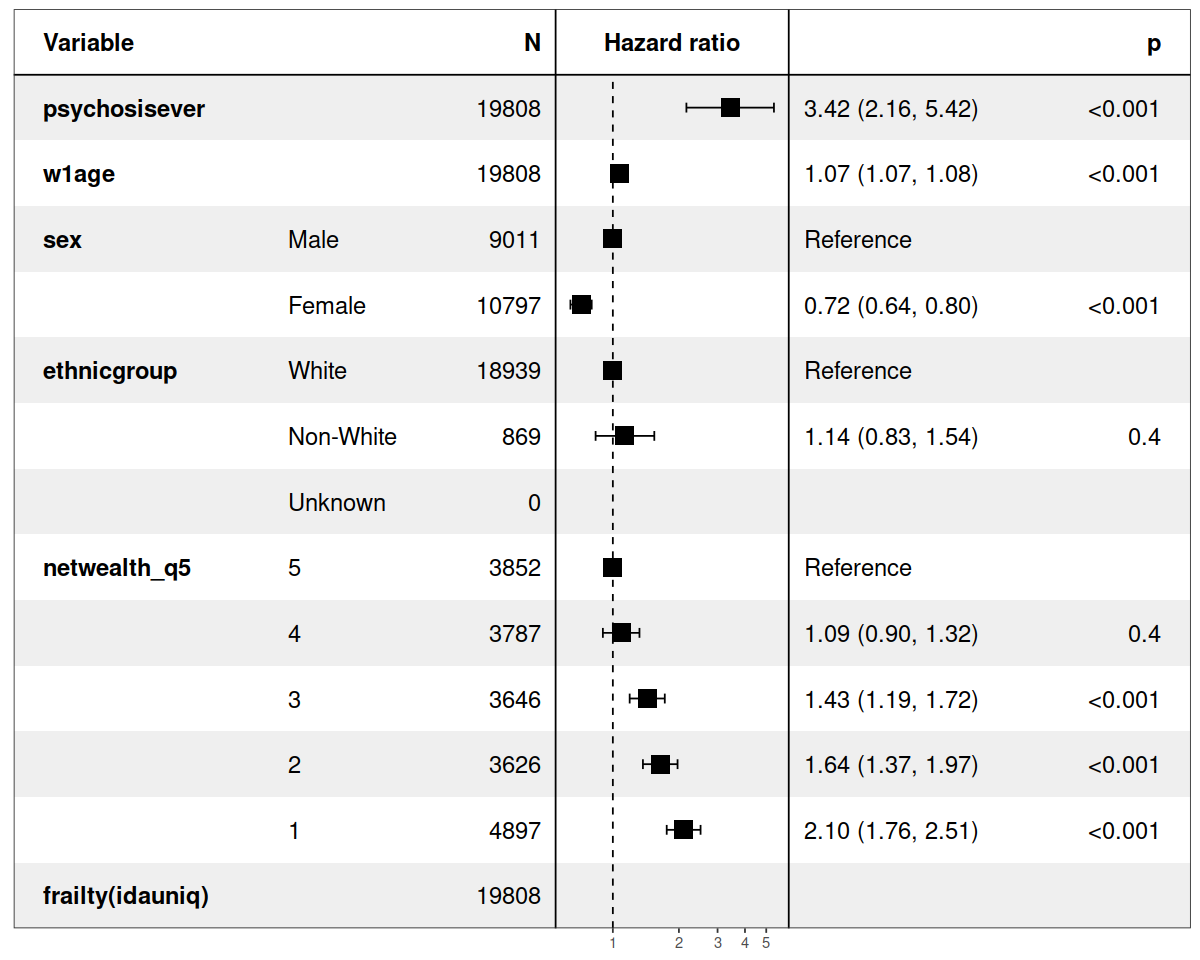

In [13]:
# Set plot size
options(repr.plot.width=10, repr.plot.height=8)

# Plot
forest_model(strokeinpsychosis_coxadjimputed)

#### Adjusted, model 2 (demographic and health behaviour covariates) with imputed data

In [14]:
# Fit model
strokeinpsychosis_coxadj2imputed <-  survival::coxph(
  Surv(fuptime, strokeever) ~ psychosisever + w1age + sex + ethnicgroup + netwealth_q5 + smokingbaseline + alcoholbaseline + vigorousactbaseline + frailty(idauniq), 
  data = strokeinpsychosis_imp
)

summary(strokeinpsychosis_coxadj2imputed)

Call:
survival::coxph(formula = Surv(fuptime, strokeever) ~ psychosisever + 
    w1age + sex + ethnicgroup + netwealth_q5 + smokingbaseline + 
    alcoholbaseline + vigorousactbaseline + frailty(idauniq), 
    data = strokeinpsychosis_imp)

  n= 19808, number of events= 1462 

                          coef      se(coef) se2      Chisq   DF   p       
psychosisever              1.185258 0.249038 0.212718   22.65    1  1.9e-06
w1age                      0.071393 0.002724 0.002495  686.87    1 2.1e-151
sexFemale                 -0.425480 0.061514 0.055221   47.84    1  4.6e-12
ethnicgroupNon-White       0.014630 0.166591 0.150183    0.01    1  9.3e-01
ethnicgroupUnknown                  0.000000 0.000000            1         
netwealth_q54              0.038408 0.102228 0.093356    0.14    1  7.1e-01
netwealth_q53              0.280959 0.099352 0.089822    8.00    1  4.7e-03
netwealth_q52              0.368956 0.099144 0.089255   13.85    1  2.0e-04
netwealth_q51              0.529560 0.

Plot as forest plot

Warning message in recalculate_width_panels(panel_positions, mapped_text = mapped_text, :
“Unable to resize forest panel to be smaller than its heading; consider a smaller text size”


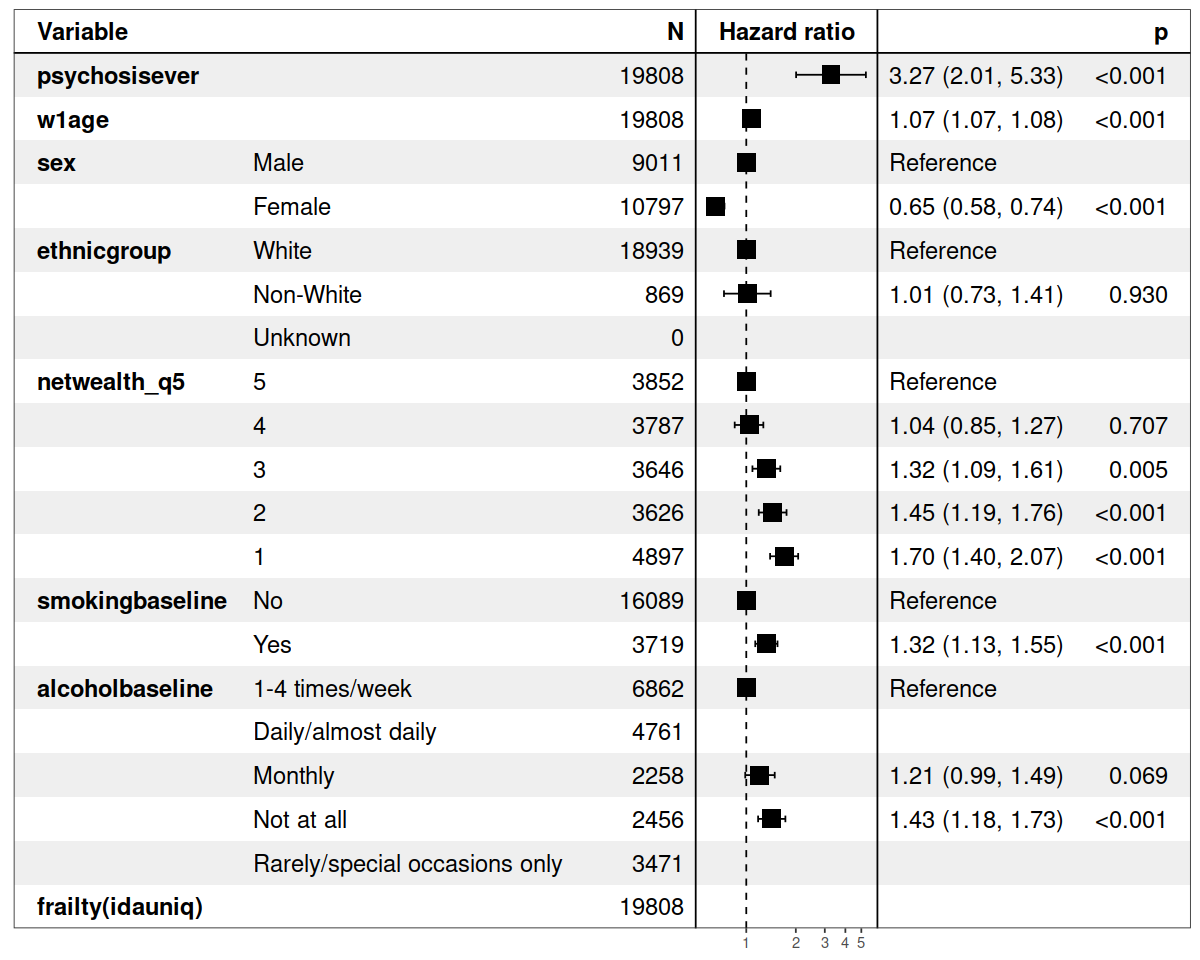

In [15]:
# Set plot size
options(repr.plot.width=10, repr.plot.height=8)

# Plot
forest_model(strokeinpsychosis_coxadj2imputed)

### Sex stratified analysis

#### Females only

In [16]:
strokeinpsychosis_imp_female <- strokeinpsychosis_imp %>%
  filter(sex == "Female")

#### Females adjusted, model 1 (demographic covariates) with imputed data

In [17]:
# Fit model
strokeinpsychosis_coxadjimputedfemale <-  survival::coxph(
  Surv(fuptime, strokeever) ~ psychosisever + w1age + sex + ethnicgroup + netwealth_q5 + frailty(idauniq),
  data = strokeinpsychosis_imp_female
)

summary(strokeinpsychosis_coxadjimputedfemale)

Call:
survival::coxph(formula = Surv(fuptime, strokeever) ~ psychosisever + 
    w1age + sex + ethnicgroup + netwealth_q5 + frailty(idauniq), 
    data = strokeinpsychosis_imp_female)

  n= 10797, number of events= 725 

                     coef     se(coef) se2      Chisq  DF    p      
psychosisever         1.42982 0.276831 0.249354  26.68   1.0 2.4e-07
w1age                 0.06987 0.003325 0.003175 441.49   1.0 5.1e-98
sexFemale                     0.000000 0.000000          1.0        
ethnicgroupNon-White  0.09278 0.235742 0.225238   0.15   1.0 6.9e-01
ethnicgroupUnknown            0.000000 0.000000          1.0        
netwealth_q54        -0.04583 0.146912 0.141329   0.10   1.0 7.6e-01
netwealth_q53         0.39075 0.134855 0.128743   8.40   1.0 3.8e-03
netwealth_q52         0.47122 0.132182 0.125893  12.71   1.0 3.6e-04
netwealth_q51         0.66524 0.130559 0.124661  25.96   1.0 3.5e-07
frailty(idauniq)                                594.30 602.7 5.9e-01

                   

#### Females adjusted model 2 (with demographic and health behaviour covariates)

In [18]:
strokeinpsychosis_coxadj2imputedfemale <-  survival::coxph(
  Surv(fuptime, strokeever) ~ psychosisever + w1age + sex + ethnicgroup + netwealth_q5 + smokingbaseline + alcoholbaseline + vigorousactbaseline + frailty(idauniq), 
  data = strokeinpsychosis_imp_female
)

summary(strokeinpsychosis_coxadj2imputedfemale)

Call:
survival::coxph(formula = Surv(fuptime, strokeever) ~ psychosisever + 
    w1age + sex + ethnicgroup + netwealth_q5 + smokingbaseline + 
    alcoholbaseline + vigorousactbaseline + frailty(idauniq), 
    data = strokeinpsychosis_imp_female)

  n= 10797, number of events= 725 

                          coef      se(coef) se2      Chisq   DF   p      
psychosisever              1.396130 0.302383 0.254918   21.32    1 3.9e-06
w1age                      0.068530 0.003741 0.003453  335.49    1 6.1e-75
sexFemale                           0.000000 0.000000            1        
ethnicgroupNon-White       0.001668 0.251769 0.231220    0.00    1 9.9e-01
ethnicgroupUnknown                  0.000000 0.000000            1        
netwealth_q54             -0.121960 0.154171 0.142560    0.63    1 4.3e-01
netwealth_q53              0.289374 0.143936 0.131391    4.04    1 4.4e-02
netwealth_q52              0.328131 0.142634 0.129752    5.29    1 2.1e-02
netwealth_q51              0.408005 0.145

#### Males only

In [19]:
strokeinpsychosis_imp_male <- strokeinpsychosis_imp %>%
  filter(sex == "Male")

#### Males adjusted, model 1 (demographic covariates) with imputed data

In [20]:
strokeinpsychosis_coxadjimputedmale <-  survival::coxph(
  Surv(fuptime, strokeever) ~ psychosisever + w1age + sex + ethnicgroup + netwealth_q5 + frailty(idauniq),
  data = strokeinpsychosis_imp_male
)

summary(strokeinpsychosis_coxadjimputedmale)

Call:
survival::coxph(formula = Surv(fuptime, strokeever) ~ psychosisever + 
    w1age + sex + ethnicgroup + netwealth_q5 + frailty(idauniq), 
    data = strokeinpsychosis_imp_male)

  n= 9011, number of events= 737 

                     coef    se(coef) se2      Chisq   DF   p      
psychosisever        0.87273 0.441968 0.388685    3.90    1 4.8e-02
w1age                0.07674 0.003832 0.003482  401.04    1 3.3e-89
sexFemale                    0.000000 0.000000            1        
ethnicgroupNon-White 0.16179 0.220600 0.195342    0.54    1 4.6e-01
ethnicgroupUnknown           0.000000 0.000000            1        
netwealth_q54        0.21061 0.136377 0.122982    2.39    1 1.2e-01
netwealth_q53        0.33109 0.136629 0.122444    5.87    1 1.5e-02
netwealth_q52        0.53498 0.136196 0.121328   15.43    1 8.6e-05
netwealth_q51        0.86967 0.131365 0.117634   43.83    1 3.6e-11
frailty(idauniq)                               1216.30 1272 8.7e-01

                     exp(coef) ex

#### Males adjusted model 2 (demographic and health behaviour covariates) with imputed data

In [21]:
strokeinpsychosis_coxadj2imputedmale <-  survival::coxph(
  Surv(fuptime, strokeever) ~ psychosisever + w1age + sex + ethnicgroup + netwealth_q5 + smokingbaseline + alcoholbaseline + vigorousactbaseline + frailty(idauniq), 
  data = strokeinpsychosis_imp_male
)

summary(strokeinpsychosis_coxadj2imputedmale)

Call:
survival::coxph(formula = Surv(fuptime, strokeever) ~ psychosisever + 
    w1age + sex + ethnicgroup + netwealth_q5 + smokingbaseline + 
    alcoholbaseline + vigorousactbaseline + frailty(idauniq), 
    data = strokeinpsychosis_imp_male)

  n= 9011, number of events= 737 

                          coef     se(coef) se2     Chisq   DF   p      
psychosisever              0.79403 0.438869 0.38846    3.27    1 7.0e-02
w1age                      0.07375 0.003975 0.00362  344.26    1 7.6e-77
sexFemale                          0.000000 0.00000            1        
ethnicgroupNon-White       0.04734 0.222195 0.19797    0.05    1 8.3e-01
ethnicgroupUnknown                 0.000000 0.00000            1        
netwealth_q54              0.16138 0.136485 0.12352    1.40    1 2.4e-01
netwealth_q53              0.25195 0.137705 0.12387    3.35    1 6.7e-02
netwealth_q52              0.39754 0.138600 0.12402    8.23    1 4.1e-03
netwealth_q51              0.65383 0.138424 0.12413   22.31   

### Age stratified analysis

#### Age <60

In [22]:
strokeinpsychosis_imp_ageless60 <- strokeinpsychosis_imp %>%
  filter(age_cat == "<60")

#### Age <60 adjusted, model 1 (demographic covariates) with imputed data

In [23]:
strokeinpsychosis_coximputedageless60adj <-  survival::coxph(
  Surv(fuptime, strokeever) ~ psychosisever + w1age + sex + ethnicgroup + netwealth_q5 + frailty(idauniq),
  data = strokeinpsychosis_imp_ageless60
)

summary(strokeinpsychosis_coximputedageless60adj)

Call:
survival::coxph(formula = Surv(fuptime, strokeever) ~ psychosisever + 
    w1age + sex + ethnicgroup + netwealth_q5 + frailty(idauniq), 
    data = strokeinpsychosis_imp_ageless60)

  n= 11465, number of events= 369 

                     coef     se(coef) se2      Chisq  DF  p      
psychosisever         1.04055 0.38912  0.343404   7.15   1 7.5e-03
w1age                 0.04985 0.01014  0.009702  24.17   1 8.8e-07
sexFemale            -0.38581 0.11216  0.105123  11.83   1 5.8e-04
ethnicgroupNon-White  0.12823 0.24526  0.228591   0.27   1 6.0e-01
ethnicgroupUnknown            0.00000  0.000000          1        
netwealth_q54        -0.03020 0.20184  0.192168   0.02   1 8.8e-01
netwealth_q53         0.22589 0.20299  0.192576   1.24   1 2.7e-01
netwealth_q52         0.47008 0.20187  0.190671   5.42   1 2.0e-02
netwealth_q51         0.93029 0.16914  0.159135  30.25   1 3.8e-08
frailty(idauniq)                                847.72 955 9.9e-01

                     exp(coef) exp(-co

#### Age <60 adjusted model 2 (demographic and health behaviour covariates) with imputed data

In [24]:
strokeinpsychosis_coxadj2imputedageless60 <-  survival::coxph(
  Surv(fuptime, strokeever) ~ psychosisever + w1age + sex + ethnicgroup + netwealth_q5 + smokingbaseline + alcoholbaseline + vigorousactbaseline + frailty(idauniq), 
  data = strokeinpsychosis_imp_ageless60
)

summary(strokeinpsychosis_coxadj2imputedageless60)

Call:
survival::coxph(formula = Surv(fuptime, strokeever) ~ psychosisever + 
    w1age + sex + ethnicgroup + netwealth_q5 + smokingbaseline + 
    alcoholbaseline + vigorousactbaseline + frailty(idauniq), 
    data = strokeinpsychosis_imp_ageless60)

  n= 11465, number of events= 369 

                          coef     se(coef) se2      Chisq   DF   p      
psychosisever              0.91424 0.46192  0.358279    3.92    1 4.8e-02
w1age                      0.04979 0.01107  0.009979   20.23    1 6.9e-06
sexFemale                 -0.56139 0.12925  0.111581   18.87    1 1.4e-05
ethnicgroupNon-White      -0.13540 0.28635  0.245123    0.22    1 6.4e-01
ethnicgroupUnknown                 0.00000  0.000000            1        
netwealth_q54             -0.16707 0.22294  0.196284    0.56    1 4.5e-01
netwealth_q53              0.08950 0.22662  0.198083    0.16    1 6.9e-01
netwealth_q52              0.17880 0.22839  0.198285    0.61    1 4.3e-01
netwealth_q51              0.47037 0.20389  0.1

#### Age 60-69

In [25]:
strokeinpsychosis_imp_age60to69 <- strokeinpsychosis_imp %>%
  filter(age_cat == "60-69")

#### Age 60-69 model 1 (demographic covariates) with imputed data

In [26]:
strokeinpsychosis_coxadjimputedage60to69 <-  survival::coxph(
  Surv(fuptime, strokeever) ~ psychosisever + w1age + sex + ethnicgroup + netwealth_q5 + frailty(idauniq),
  data = strokeinpsychosis_imp_age60to69
)

summary(strokeinpsychosis_coxadjimputedage60to69)

Call:
survival::coxph(formula = Surv(fuptime, strokeever) ~ psychosisever + 
    w1age + sex + ethnicgroup + netwealth_q5 + frailty(idauniq), 
    data = strokeinpsychosis_imp_age60to69)

  n= 4280, number of events= 420 

                     coef    se(coef) se2    Chisq   DF   p      
psychosisever         1.6449 0.64140  0.4881    6.58    1 1.0e-02
w1age                 0.1042 0.02129  0.0180   23.95    1 9.9e-07
sexFemale            -0.4285 0.11992  0.1009   12.77    1 3.5e-04
ethnicgroupNon-White -0.1425 0.34129  0.2825    0.17    1 6.8e-01
ethnicgroupUnknown           0.00000  0.0000            1        
netwealth_q54         0.2273 0.18926  0.1636    1.44    1 2.3e-01
netwealth_q53         0.5384 0.18565  0.1587    8.41    1 3.7e-03
netwealth_q52         0.8927 0.19053  0.1610   21.95    1 2.8e-06
netwealth_q51         1.0576 0.18692  0.1574   32.02    1 1.5e-08
frailty(idauniq)                             1060.05 1159 9.8e-01

                     exp(coef) exp(-coef) lower .9

#### Age 60-69 model 2 (demographic and health behaviour covariates) with imputed data

In [27]:
strokeinpsychosis_coxadj2imputedage60to69 <-  survival::coxph(
  Surv(fuptime, strokeever) ~ psychosisever + w1age + sex + ethnicgroup + netwealth_q5 + smokingbaseline + alcoholbaseline + vigorousactbaseline + frailty(idauniq), 
  data = strokeinpsychosis_imp_age60to69
)

summary(strokeinpsychosis_coxadj2imputedage60to69)

Call:
survival::coxph(formula = Surv(fuptime, strokeever) ~ psychosisever + 
    w1age + sex + ethnicgroup + netwealth_q5 + smokingbaseline + 
    alcoholbaseline + vigorousactbaseline + frailty(idauniq), 
    data = strokeinpsychosis_imp_age60to69)

  n= 4280, number of events= 420 

                          coef     se(coef) se2     Chisq   DF   p      
psychosisever              1.72916 0.69523  0.50223    6.19    1 1.3e-02
w1age                      0.10846 0.02278  0.01845   22.66    1 1.9e-06
sexFemale                 -0.51730 0.13271  0.10699   15.19    1 9.7e-05
ethnicgroupNon-White      -0.23214 0.36719  0.29133    0.40    1 5.3e-01
ethnicgroupUnknown                 0.00000  0.00000            1        
netwealth_q54              0.21137 0.20180  0.16682    1.10    1 2.9e-01
netwealth_q53              0.49934 0.20041  0.16359    6.21    1 1.3e-02
netwealth_q52              0.83588 0.20889  0.16872   16.01    1 6.3e-05
netwealth_q51              0.94156 0.21171  0.16970   19.

#### Age 70+

In [28]:
strokeinpsychosis_imp_age70plus <- strokeinpsychosis_imp %>%
  filter(age_cat == "70+")

#### Age 70+ model 1 (demographic covariates) with imputed data

In [29]:
strokeinpsychosis_coxadjimputedage70plus <-  survival::coxph(
  Surv(fuptime, strokeever) ~ psychosisever + w1age + sex + ethnicgroup + netwealth_q5 + frailty(idauniq),
  data = strokeinpsychosis_imp_age70plus
)

summary(strokeinpsychosis_coxadjimputedage70plus)

Call:
survival::coxph(formula = Surv(fuptime, strokeever) ~ psychosisever + 
    w1age + sex + ethnicgroup + netwealth_q5 + frailty(idauniq), 
    data = strokeinpsychosis_imp_age70plus)

  n= 4061, number of events= 673 

                     coef     se(coef) se2      Chisq DF  p      
psychosisever         1.31014 0.319857 0.319431 16.78 1.0 4.2e-05
w1age                 0.04817 0.007347 0.007343 42.99 1.0 5.5e-11
sexFemale            -0.22716 0.078574 0.078528  8.36 1.0 3.8e-03
ethnicgroupNon-White  0.23433 0.264444 0.264251  0.79 1.0 3.8e-01
ethnicgroupUnknown            0.000000 0.000000       1.0        
netwealth_q54         0.04466 0.138734 0.138664  0.10 1.0 7.5e-01
netwealth_q53         0.27443 0.128646 0.128575  4.55 1.0 3.3e-02
netwealth_q52         0.30321 0.124800 0.124734  5.90 1.0 1.5e-02
netwealth_q51         0.38470 0.138107 0.138032  7.76 1.0 5.3e-03
frailty(idauniq)                                 3.71 3.7 4.0e-01

                     exp(coef) exp(-coef) lower .9

#### Age 70+ adjusted model 2 (with demographic and health behaviour covariates)

In [30]:
strokeinpsychosis_coxadj2imputedage70plus <-  survival::coxph(
  Surv(fuptime, strokeever) ~ psychosisever + w1age + sex + ethnicgroup + netwealth_q5 + smokingbaseline + alcoholbaseline + vigorousactbaseline + frailty(idauniq), 
  data = strokeinpsychosis_imp_age70plus
)

summary(strokeinpsychosis_coxadj2imputedage70plus)

Call:
survival::coxph(formula = Surv(fuptime, strokeever) ~ psychosisever + 
    w1age + sex + ethnicgroup + netwealth_q5 + smokingbaseline + 
    alcoholbaseline + vigorousactbaseline + frailty(idauniq), 
    data = strokeinpsychosis_imp_age70plus)

  n= 4061, number of events= 673 

                          coef     se(coef) se2      Chisq  DF    p      
psychosisever              1.39983 0.360128 0.323654  15.11   1.0 1.0e-04
w1age                      0.04849 0.007897 0.007522  37.71   1.0 8.2e-10
sexFemale                 -0.28652 0.085719 0.081547  11.17   1.0 8.3e-04
ethnicgroupNon-White       0.13888 0.283614 0.267050   0.24   1.0 6.2e-01
ethnicgroupUnknown                 0.000000 0.000000          1.0        
netwealth_q54              0.03371 0.145202 0.138920   0.05   1.0 8.2e-01
netwealth_q53              0.26184 0.136401 0.130010   3.68   1.0 5.5e-02
netwealth_q52              0.26741 0.133267 0.127170   4.03   1.0 4.5e-02
netwealth_q51              0.30384 0.149628 0.14

## Psychosis in the stroke population survival analyses

### Cox proportional hazards regression models

#### Adjusted, model 1 (demographic covariates) with imputed data

In [31]:
# Fit model
psychosisinstroke_coxadjimputed <-  survival::coxph(
  Surv(fuptime, psychosisever) ~ strokeever + w1age + sex + ethnicgroup + netwealth_q5 + frailty(idauniq), 
  data = psychosisinstroke_imp
)

summary(psychosisinstroke_coxadjimputed)

Call:
survival::coxph(formula = Surv(fuptime, psychosisever) ~ strokeever + 
    w1age + sex + ethnicgroup + netwealth_q5 + frailty(idauniq), 
    data = psychosisinstroke_imp)

  n= 19808, number of events= 162 

                     coef     se(coef) se2      Chisq   DF   p      
strokeever            1.56104 0.347657 0.263484   20.16    1 7.1e-06
w1age                -0.02277 0.008953 0.007361    6.47    1 1.1e-02
sexFemale             0.16150 0.210591 0.168489    0.59    1 4.4e-01
ethnicgroupNon-White -0.35660 0.545761 0.442184    0.43    1 5.1e-01
ethnicgroupUnknown            0.000000 0.000000            1        
netwealth_q54         0.58178 0.375789 0.319167    2.40    1 1.2e-01
netwealth_q53         0.57599 0.382460 0.325161    2.27    1 1.3e-01
netwealth_q52         0.78373 0.376603 0.318574    4.33    1 3.7e-02
netwealth_q51         1.79538 0.337233 0.284945   28.34    1 1.0e-07
frailty(idauniq)                                2426.38 6961 1.0e+00

                     exp(c

Plot as forest plot

Warning message in recalculate_width_panels(panel_positions, mapped_text = mapped_text, :
“Unable to resize forest panel to be smaller than its heading; consider a smaller text size”


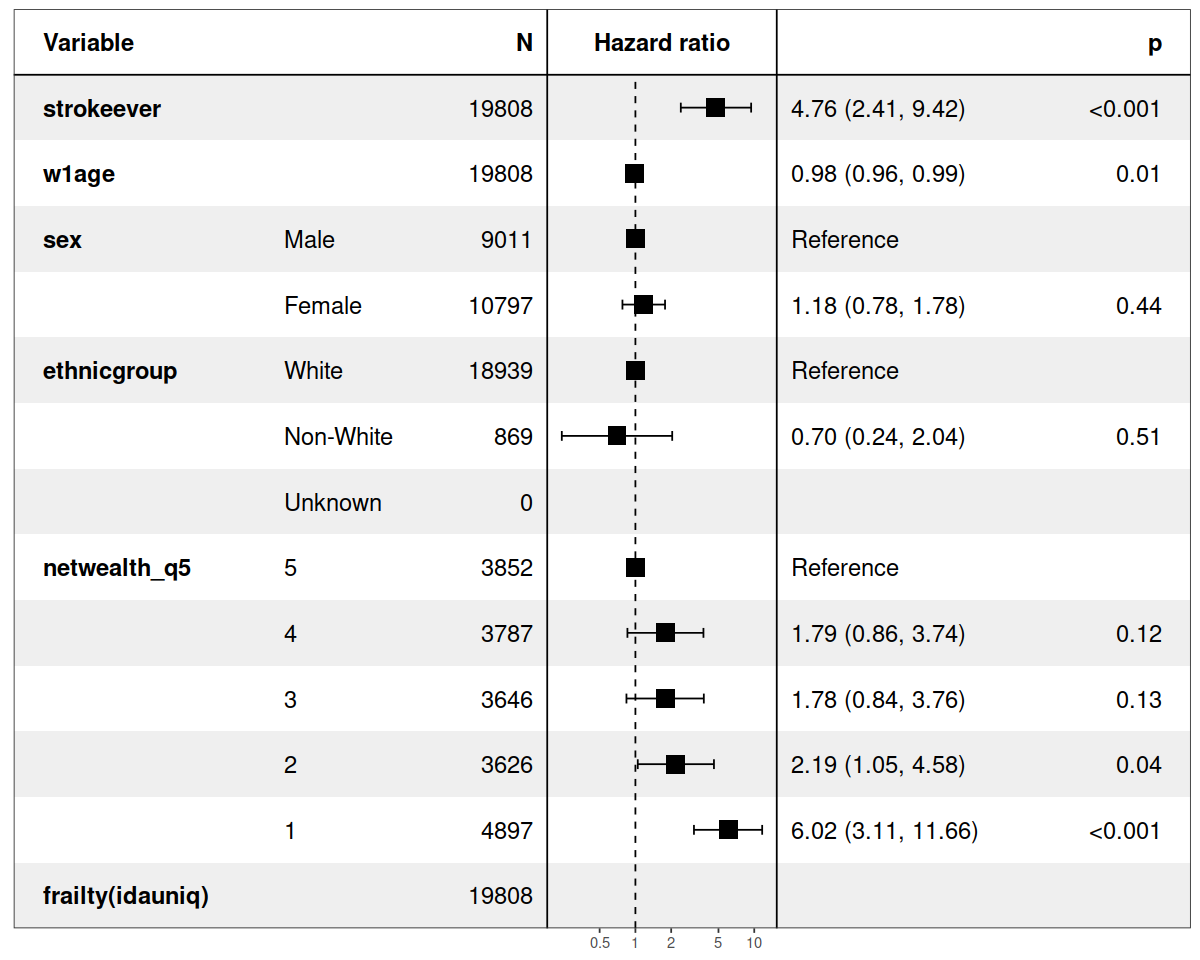

In [32]:
# Set plot size
options(repr.plot.width=10, repr.plot.height=8)

# Plot
forest_model(psychosisinstroke_coxadjimputed)

#### Adjusted, model 2 (demographic and health behaviour covariates) with imputed data

In [33]:
# Fit model
psychosisinstroke_coxadj2imputed <-  survival::coxph(
  Surv(fuptime, psychosisever) ~ strokeever + w1age + sex + ethnicgroup + netwealth_q5 + smokingbaseline + alcoholbaseline + vigorousactbaseline + frailty(idauniq), 
  data = psychosisinstroke_imp
)

summary(psychosisinstroke_coxadj2imputed)

Call:
survival::coxph(formula = Surv(fuptime, psychosisever) ~ strokeever + 
    w1age + sex + ethnicgroup + netwealth_q5 + smokingbaseline + 
    alcoholbaseline + vigorousactbaseline + frailty(idauniq), 
    data = psychosisinstroke_imp)

  n= 19808, number of events= 162 

                          coef     se(coef) se2      Chisq   DF   p      
strokeever                 1.62026 0.364698 0.273453   19.74    1 8.9e-06
w1age                     -0.03527 0.009774 0.007908   13.02    1 3.1e-04
sexFemale                 -0.07517 0.227460 0.179478    0.11    1 7.4e-01
ethnicgroupNon-White      -0.76959 0.577902 0.461618    1.77    1 1.8e-01
ethnicgroupUnknown                 0.000000 0.000000            1        
netwealth_q54              0.45839 0.394321 0.327695    1.35    1 2.5e-01
netwealth_q53              0.38623 0.403995 0.335244    0.91    1 3.4e-01
netwealth_q52              0.38221 0.400861 0.330663    0.91    1 3.4e-01
netwealth_q51              1.03334 0.379395 0.307222    7

Plot as forest plot

Warning message in recalculate_width_panels(panel_positions, mapped_text = mapped_text, :
“Unable to resize forest panel to be smaller than its heading; consider a smaller text size”


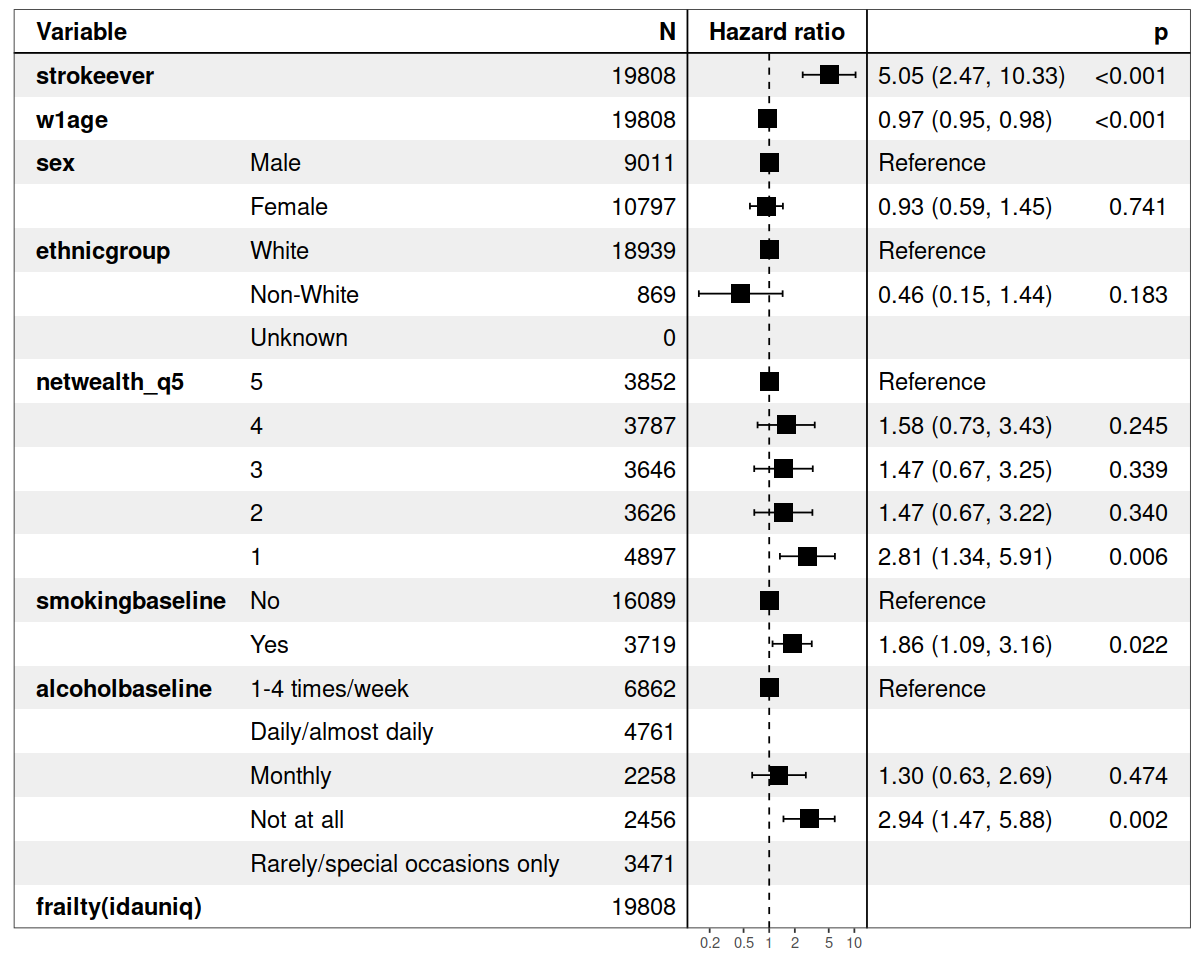

In [34]:
# Set plot size
options(repr.plot.width=10, repr.plot.height=8)

# Plot
forest_model(psychosisinstroke_coxadj2imputed)

### Sex stratified analysis

#### Females only

In [35]:
psychosisinstroke_imp_female <- psychosisinstroke_imp %>%
  filter(sex == "Female")

#### Females adjusted, model 1 (demographic covariates) with imputed data

In [36]:
# Fit model
psychosisinstroke_coxadjimputedfemale <-  survival::coxph(
  Surv(fuptime, psychosisever) ~ strokeever + w1age + sex + ethnicgroup + netwealth_q5 + frailty(idauniq), 
  data = psychosisinstroke_imp_female
)

summary(psychosisinstroke_coxadjimputedfemale)

Call:
survival::coxph(formula = Surv(fuptime, psychosisever) ~ strokeever + 
    w1age + sex + ethnicgroup + netwealth_q5 + frailty(idauniq), 
    data = psychosisinstroke_imp_female)

  n= 10797, number of events= 96 

                     coef      se(coef) se2      Chisq   DF   p      
strokeever            1.730340 0.37676  0.306440   21.09    1 4.4e-06
w1age                -0.008069 0.01006  0.008888    0.64    1 4.2e-01
sexFemale                      0.00000  0.000000            1        
ethnicgroupNon-White -0.400390 0.67196  0.600362    0.36    1 5.5e-01
ethnicgroupUnknown             0.00000  0.000000            1        
netwealth_q54         0.472639 0.41246  0.363952    1.31    1 2.5e-01
netwealth_q53        -0.053053 0.45011  0.404272    0.01    1 9.1e-01
netwealth_q52         0.409861 0.41726  0.369692    0.96    1 3.3e-01
netwealth_q51         0.919131 0.38145  0.334728    5.81    1 1.6e-02
frailty(idauniq)                                 1056.98 2317 1.0e+00

         

#### Females adjusted model 2 (with demographic and health behaviour covariates)

In [37]:
psychosisinstroke_coxadj2imputedfemale <-  survival::coxph(
  Surv(fuptime, psychosisever) ~ strokeever + w1age + sex + ethnicgroup + netwealth_q5 + smokingbaseline + alcoholbaseline + vigorousactbaseline + frailty(idauniq), 
  data = psychosisinstroke_imp_female
)

summary(psychosisinstroke_coxadj2imputedfemale)

Call:
survival::coxph(formula = Surv(fuptime, psychosisever) ~ strokeever + 
    w1age + sex + ethnicgroup + netwealth_q5 + smokingbaseline + 
    alcoholbaseline + vigorousactbaseline + frailty(idauniq), 
    data = psychosisinstroke_imp_female)

  n= 10797, number of events= 96 

                          coef     se(coef) se2      Chisq   DF   p      
strokeever                 1.77590 0.41575  0.322928   18.25    1 1.9e-05
w1age                     -0.02331 0.01139  0.009519    4.19    1 4.1e-02
sexFemale                          0.00000  0.000000            1        
ethnicgroupNon-White      -0.83492 0.73595  0.627736    1.29    1 2.6e-01
ethnicgroupUnknown                 0.00000  0.000000            1        
netwealth_q54              0.33377 0.45226  0.376059    0.54    1 4.6e-01
netwealth_q53             -0.35386 0.49468  0.418708    0.51    1 4.7e-01
netwealth_q52             -0.02193 0.46449  0.387753    0.00    1 9.6e-01
netwealth_q51              0.15406 0.45431  0.37242

#### Males only

In [38]:
psychosisinstroke_imp_male <- psychosisinstroke_imp %>%
  filter(sex == "Male")

#### Males adjusted, model 1 (demographic covariates) with imputed data

In [39]:
psychosisinstroke_coxadjimputedmale <-  survival::coxph(
  Surv(fuptime, psychosisever) ~ strokeever + w1age + sex + ethnicgroup + netwealth_q5 + frailty(idauniq), 
  data = psychosisinstroke_imp_male
)

summary(psychosisinstroke_coxadjimputedmale)

Call:
survival::coxph(formula = Surv(fuptime, psychosisever) ~ strokeever + 
    w1age + sex + ethnicgroup + netwealth_q5 + frailty(idauniq), 
    data = psychosisinstroke_imp_male)

  n= 9011, number of events= 66 

                     coef     se(coef) se2     Chisq  DF   p      
strokeever            1.03961 0.58365  0.45672   3.17    1 7.5e-02
w1age                -0.04261 0.01515  0.01283   7.91    1 4.9e-03
sexFemale                     0.00000  0.00000           1        
ethnicgroupNon-White -0.28413 0.79604  0.63554   0.13    1 7.2e-01
ethnicgroupUnknown            0.00000  0.00000           1        
netwealth_q54         0.56062 0.70463  0.64787   0.63    1 4.3e-01
netwealth_q53         1.44027 0.65185  0.58907   4.88    1 2.7e-02
netwealth_q52         1.21061 0.68380  0.61834   3.13    1 7.7e-02
netwealth_q51         2.70530 0.59854  0.54731  20.43    1 6.2e-06
frailty(idauniq)                               952.62 2630 1.0e+00

                     exp(coef) exp(-coef) low

#### Males adjusted model 2 (demographic and health behaviour covariates) with imputed data

In [40]:
strokeinpsychosis_coxadj2imputedmale <-  survival::coxph(
  Surv(fuptime, strokeever) ~ psychosisever + w1age + sex + ethnicgroup + netwealth_q5 + smokingbaseline + alcoholbaseline + vigorousactbaseline + frailty(idauniq), 
  data = strokeinpsychosis_imp_male
)

summary(strokeinpsychosis_coxadj2imputedmale)

Call:
survival::coxph(formula = Surv(fuptime, strokeever) ~ psychosisever + 
    w1age + sex + ethnicgroup + netwealth_q5 + smokingbaseline + 
    alcoholbaseline + vigorousactbaseline + frailty(idauniq), 
    data = strokeinpsychosis_imp_male)

  n= 9011, number of events= 737 

                          coef     se(coef) se2     Chisq   DF   p      
psychosisever              0.79403 0.438869 0.38846    3.27    1 7.0e-02
w1age                      0.07375 0.003975 0.00362  344.26    1 7.6e-77
sexFemale                          0.000000 0.00000            1        
ethnicgroupNon-White       0.04734 0.222195 0.19797    0.05    1 8.3e-01
ethnicgroupUnknown                 0.000000 0.00000            1        
netwealth_q54              0.16138 0.136485 0.12352    1.40    1 2.4e-01
netwealth_q53              0.25195 0.137705 0.12387    3.35    1 6.7e-02
netwealth_q52              0.39754 0.138600 0.12402    8.23    1 4.1e-03
netwealth_q51              0.65383 0.138424 0.12413   22.31   

### Age stratified analysis

#### Age <60

In [41]:
psychosisinstroke_imp_ageless60 <- psychosisinstroke_imp %>%
  filter(age_cat == "<60")

#### Age <60 adjusted, model 1 (demographic covariates) with imputed data

In [42]:
psychosisinstroke_coxadjimputedageless60 <-  survival::coxph(
  Surv(fuptime, psychosisever) ~ strokeever + w1age + sex + ethnicgroup + netwealth_q5 + frailty(idauniq), 
  data = psychosisinstroke_imp_ageless60
)

summary(psychosisinstroke_coxadjimputedageless60)

Call:
survival::coxph(formula = Surv(fuptime, psychosisever) ~ strokeever + 
    w1age + sex + ethnicgroup + netwealth_q5 + frailty(idauniq), 
    data = psychosisinstroke_imp_ageless60)

  n= 11465, number of events= 111 

                     coef      se(coef) se2     Chisq   DF   p      
strokeever            1.245604 0.50443  0.37907    6.10    1 1.4e-02
w1age                 0.005168 0.01775  0.01519    0.08    1 7.7e-01
sexFemale            -0.079177 0.23574  0.19682    0.11    1 7.4e-01
ethnicgroupNon-White -0.178272 0.51932  0.43493    0.12    1 7.3e-01
ethnicgroupUnknown             0.00000  0.00000            1        
netwealth_q54         0.793856 0.48316  0.43997    2.70    1 1.0e-01
netwealth_q53         0.695338 0.50333  0.45918    1.91    1 1.7e-01
netwealth_q52         1.083049 0.48370  0.43710    5.01    1 2.5e-02
netwealth_q51         2.041793 0.42442  0.38670   23.14    1 1.5e-06
frailty(idauniq)                                1334.27 3120 1.0e+00

                

#### Age <60 adjusted model 2 (demographic and health behaviour covariates) with imputed data

In [43]:
psychosisinstroke_coxadj2imputedageless60 <-  survival::coxph(
  Surv(fuptime, psychosisever) ~ strokeever + w1age + sex + ethnicgroup + netwealth_q5 + smokingbaseline + alcoholbaseline + vigorousactbaseline + frailty(idauniq), 
  data = psychosisinstroke_imp_ageless60
)

summary(psychosisinstroke_coxadj2imputedageless60)

Call:
survival::coxph(formula = Surv(fuptime, psychosisever) ~ strokeever + 
    w1age + sex + ethnicgroup + netwealth_q5 + smokingbaseline + 
    alcoholbaseline + vigorousactbaseline + frailty(idauniq), 
    data = psychosisinstroke_imp_ageless60)

  n= 11465, number of events= 111 

                          coef      se(coef) se2     Chisq   DF   p      
strokeever                 1.203611 0.55839  0.40108    4.65    1 3.1e-02
w1age                      0.001293 0.01954  0.01608    0.00    1 9.5e-01
sexFemale                 -0.220240 0.26479  0.21214    0.69    1 4.1e-01
ethnicgroupNon-White      -0.608125 0.58947  0.47178    1.06    1 3.0e-01
ethnicgroupUnknown                  0.00000  0.00000            1        
netwealth_q54              0.725673 0.51766  0.45020    1.97    1 1.6e-01
netwealth_q53              0.606604 0.54200  0.47072    1.25    1 2.6e-01
netwealth_q52              0.748654 0.52230  0.44924    2.05    1 1.5e-01
netwealth_q51              1.347350 0.47935  0.

#### Age 60-69

In [44]:
psychosisinstroke_imp_age60to69 <- psychosisinstroke_imp %>%
  filter(age_cat == "60-69")

#### Age 60-69 model 1 (demographic covariates) with imputed data

In [45]:
psychosisinstroke_coxadjimputedage60to69 <-  survival::coxph(
  Surv(fuptime, psychosisever) ~ strokeever + w1age + sex + ethnicgroup + netwealth_q5 + frailty(idauniq), 
  data = psychosisinstroke_imp_age60to69
)

summary(psychosisinstroke_coxadjimputedage60to69)

Call:
survival::coxph(formula = Surv(fuptime, psychosisever) ~ strokeever + 
    w1age + sex + ethnicgroup + netwealth_q5 + frailty(idauniq), 
    data = psychosisinstroke_imp_age60to69)

  n= 4280, number of events= 24 

                     coef      se(coef)  se2       Chisq DF p    
strokeever             1.10454 5.131e-01 5.131e-01 4.63  1  0.031
w1age                 -0.01889 7.246e-02 7.246e-02 0.07  1  0.790
sexFemale              0.76002 4.508e-01 4.508e-01 2.84  1  0.092
ethnicgroupNon-White -18.25569 1.041e+04 1.041e+04 0.00  1  1.000
ethnicgroupUnknown             0.000e+00 0.000e+00       1       
netwealth_q54          0.13173 7.075e-01 7.075e-01 0.03  1  0.850
netwealth_q53          0.64610 6.489e-01 6.489e-01 0.99  1  0.320
netwealth_q52          0.15587 7.689e-01 7.689e-01 0.04  1  0.840
netwealth_q51          1.03218 6.336e-01 6.336e-01 2.65  1  0.100
frailty(idauniq)                                   0.00  0  0.830

                     exp(coef) exp(-coef) lower .95

#### Age 60-69 model 2 (demographic and health behaviour covariates) with imputed data

In [46]:
psychosisinstroke_coxadj2imputedage60to69 <-  survival::coxph(
  Surv(fuptime, psychosisever) ~ strokeever + w1age + sex + ethnicgroup + netwealth_q5 + smokingbaseline + alcoholbaseline + vigorousactbaseline + frailty(idauniq), 
  data = psychosisinstroke_imp_age60to69
)

summary(psychosisinstroke_coxadj2imputedage60to69)

Call:
survival::coxph(formula = Surv(fuptime, psychosisever) ~ strokeever + 
    w1age + sex + ethnicgroup + netwealth_q5 + smokingbaseline + 
    alcoholbaseline + vigorousactbaseline + frailty(idauniq), 
    data = psychosisinstroke_imp_age60to69)

  n= 4280, number of events= 24 

                          coef     se(coef) se2     Chisq DF    p     
strokeever                 1.14298 0.53731  0.51747  4.53  1.00 0.0330
w1age                     -0.05875 0.07605  0.07424  0.60  1.00 0.4400
sexFemale                  0.32918 0.47300  0.46424  0.48  1.00 0.4900
ethnicgroupNon-White               0.00000  0.00000        1.00       
ethnicgroupUnknown                 0.00000  0.00000        1.00       
netwealth_q54             -0.08301 0.72347  0.71209  0.01  1.00 0.9100
netwealth_q53              0.31109 0.67247  0.65928  0.21  1.00 0.6400
netwealth_q52             -0.31392 0.79953  0.78637  0.15  1.00 0.6900
netwealth_q51              0.37936 0.67900  0.66376  0.31  1.00 0.5800
smoki

#### Age 70+

In [47]:
psychosisinstroke_imp_age70plus <- psychosisinstroke_imp %>%
  filter(age_cat == "70+")

#### Age 70+ model 1 (demographic covariates) with imputed data

In [48]:
psychosisinstroke_coxadjimputedage70plus <-  survival::coxph(
  Surv(fuptime, psychosisever) ~ strokeever + w1age + sex + ethnicgroup + netwealth_q5 + frailty(idauniq), 
  data = psychosisinstroke_imp_age70plus
)

summary(psychosisinstroke_coxadjimputedage70plus)

Call:
survival::coxph(formula = Surv(fuptime, psychosisever) ~ strokeever + 
    w1age + sex + ethnicgroup + netwealth_q5 + frailty(idauniq), 
    data = psychosisinstroke_imp_age70plus)

  n= 4061, number of events= 27 

                     coef     se(coef) se2    Chisq  DF   p      
strokeever            2.48265 0.65216  0.5473  14.49    1 0.00014
w1age                 0.01244 0.05267  0.0422   0.06    1 0.81000
sexFemale             0.72713 0.59152  0.4746   1.51    1 0.22000
ethnicgroupNon-White          0.00000  0.0000           1        
ethnicgroupUnknown            0.00000  0.0000           1        
netwealth_q54         0.32372 0.88456  0.6726   0.13    1 0.71000
netwealth_q53        -0.36735 0.89570  0.6909   0.17    1 0.68000
netwealth_q52        -0.09972 0.85409  0.6575   0.01    1 0.91000
netwealth_q51        -0.13302 0.95711  0.7443   0.02    1 0.89000
frailty(idauniq)                              400.56 1255 1.00000

                     exp(coef) exp(-coef) lower .95

#### Age 70+ adjusted model 2 (with demographic and health behaviour covariates)

In [49]:
psychosisinstroke_coxadj2imputedage70plus <-  survival::coxph(
  Surv(fuptime, psychosisever) ~ strokeever + w1age + sex + ethnicgroup + netwealth_q5 + smokingbaseline + alcoholbaseline + vigorousactbaseline + frailty(idauniq), 
  data = psychosisinstroke_imp_age70plus
)

summary(psychosisinstroke_coxadj2imputedage70plus)

Warning message in coxpenal.fit(X, Y, istrat, offset, init = init, control, weights = weights, :
“Inner loop failed to coverge for iterations 9 10”
Warning message in sqrt((diag(object$var2))[kk]):
“NaNs produced”
Warning message in sqrt((diag(object$var2))[kk]):
“NaNs produced”
Warning message in sqrt((diag(object$var2))[kk]):
“NaNs produced”


Call:
survival::coxph(formula = Surv(fuptime, psychosisever) ~ strokeever + 
    w1age + sex + ethnicgroup + netwealth_q5 + smokingbaseline + 
    alcoholbaseline + vigorousactbaseline + frailty(idauniq), 
    data = psychosisinstroke_imp_age70plus)

  n= 4061, number of events= 27 

                          coef      se(coef) se2    Chisq  DF   p      
strokeever                 4.078022 1.0567   0.7699  14.89    1 0.00011
w1age                      0.031598 0.1052   0.0562   0.09    1 0.76000
sexFemale                  0.593451 1.2018   0.5515   0.24    1 0.62000
ethnicgroupNon-White                0.0000   0.0000           1        
ethnicgroupUnknown                  0.0000   0.0000           1        
netwealth_q54              0.003631 1.6426   0.6050   0.00    1 1.00000
netwealth_q53             -0.743339 1.9440            0.15    1 0.70000
netwealth_q52             -1.154581 1.7243            0.45    1 0.50000
netwealth_q51             -2.196946 1.7829   0.9637   1.52    1 0.2

## Analysis platform details and software versions

In [50]:
version

               _                           
platform       x86_64-pc-linux-gnu         
arch           x86_64                      
os             linux-gnu                   
system         x86_64, linux-gnu           
status                                     
major          4                           
minor          0.3                         
year           2020                        
month          10                          
day            10                          
svn rev        79318                       
language       R                           
version.string R version 4.0.3 (2020-10-10)
nickname       Bunny-Wunnies Freak Out     

In [51]:
packageVersion("dplyr")

[1] ‘1.0.9’

In [52]:
packageVersion("survival")

[1] ‘3.2.7’

In [53]:
packageVersion("survminer")

[1] ‘0.4.9’

In [54]:
packageVersion("forestmodel")

[1] ‘0.6.2’

In [55]:
packageVersion("missForest")

[1] ‘1.4’

In [56]:
packageVersion("doParallel")

[1] ‘1.0.17’